In [0]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline

In [0]:
X_train = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/train.csv', parse_dates=[2], low_memory=False)
X_test = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/test.csv', parse_dates=[3], low_memory=False)
store = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/store.csv')

In [0]:
def get_processed_data_with_store(df, store):
  # 1. merge store
  df = pd.merge(df, store, on="Store", how="left")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Day'] = df['Date'].dt.day
  df['DayOfYear'] = df['Date'].dt.dayofyear
  df['WeekOfYear'] = df['Date'].dt.weekofyear
  df.drop("Date", axis=1, inplace=True)
  df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + \
          (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
  df['PromoOpen'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4.0
  df['PromoOpen'] = df['PromoOpen'].apply(lambda x: x if x > 0 else 0)
  month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
  df['IsPromoMonth'] = 0
  df['MonthStr'] = df.Month.map(month2str)
  for interval in df.PromoInterval.unique():
    if interval != '' and type(interval)==str:
        for month in interval.split(','):
            df.loc[(df.MonthStr == month) & (df.PromoInterval == interval), 'IsPromoMonth'] = 1
  df.drop('MonthStr', axis=1, inplace=True)
  return df

In [0]:
X_train = get_processed_data_with_store(X_train, store)

In [0]:
X_train = X_train[(X_train["Open"] != 0) & (X_train['Sales'] != 0)]

In [15]:
store[pd.isnull(store.CompetitionDistance)] # 没有 competition distance

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [0]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.fillna(0, inplace = True)

In [0]:
train_store_sales_overview = X_train.groupby('StoreType')['Sales', 'Customers'].sum()
train_store_sales_overview['SalesPerCustomers'] = train_store_sales_overview['Sales']/train_store_sales_overview['Customers']
train_store_sales_overview = train_store_sales_overview.reset_index()

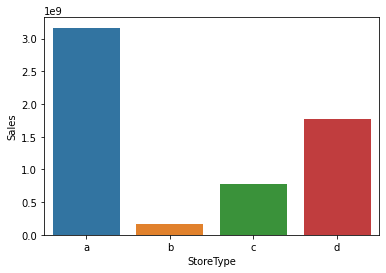

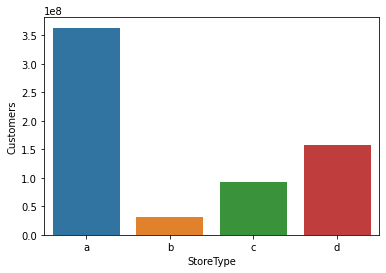

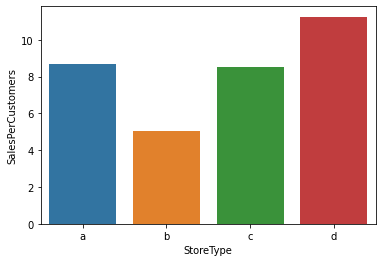

In [20]:
for col in ['Sales', 'Customers', 'SalesPerCustomers']:
# sns.barplot(x='StoreType',y='Sales',data = train_store_sales_overview,ax=axis1)
# sns.barplot(x='StoreType',y='Customers',data = train_store_sales_overview)
    sns.barplot(x='StoreType',y=col, data=train_store_sales_overview)
    plt.show()

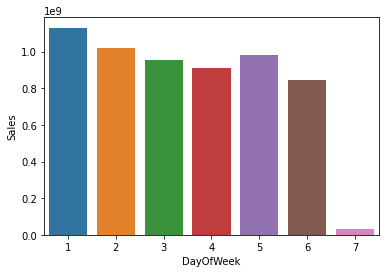

In [22]:
train_store_dayofweek_overview = X_train.groupby('DayOfWeek')['Sales'].sum()
train_store_dayofweek_overview = train_store_dayofweek_overview.reset_index()
sns.barplot(x='DayOfWeek',y='Sales', data=train_store_dayofweek_overview)

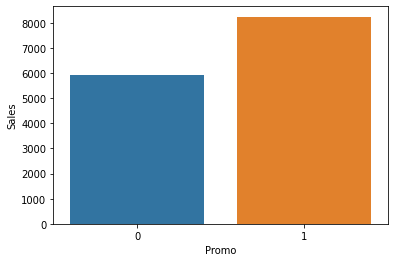

In [23]:
sns.barplot(x='Promo',y='Sales', data=X_train)

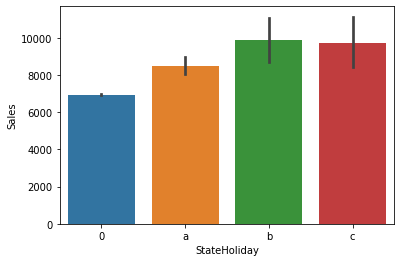

In [25]:
sns.barplot(x='StateHoliday',y='Sales', data=X_train)

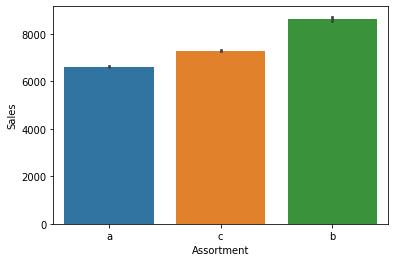

In [26]:
sns.barplot(x='Assortment',y='Sales', data=X_train)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


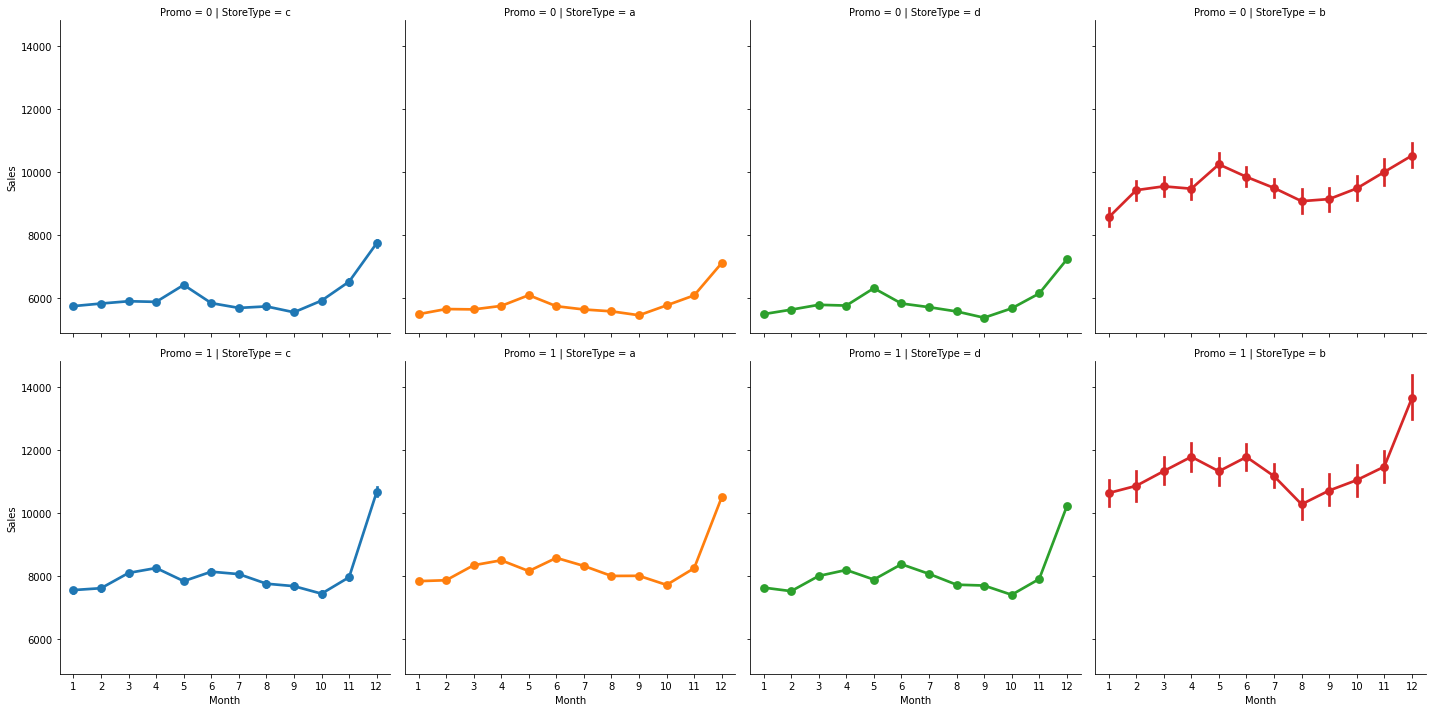

In [28]:
sns.factorplot(data = X_train, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               ) 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


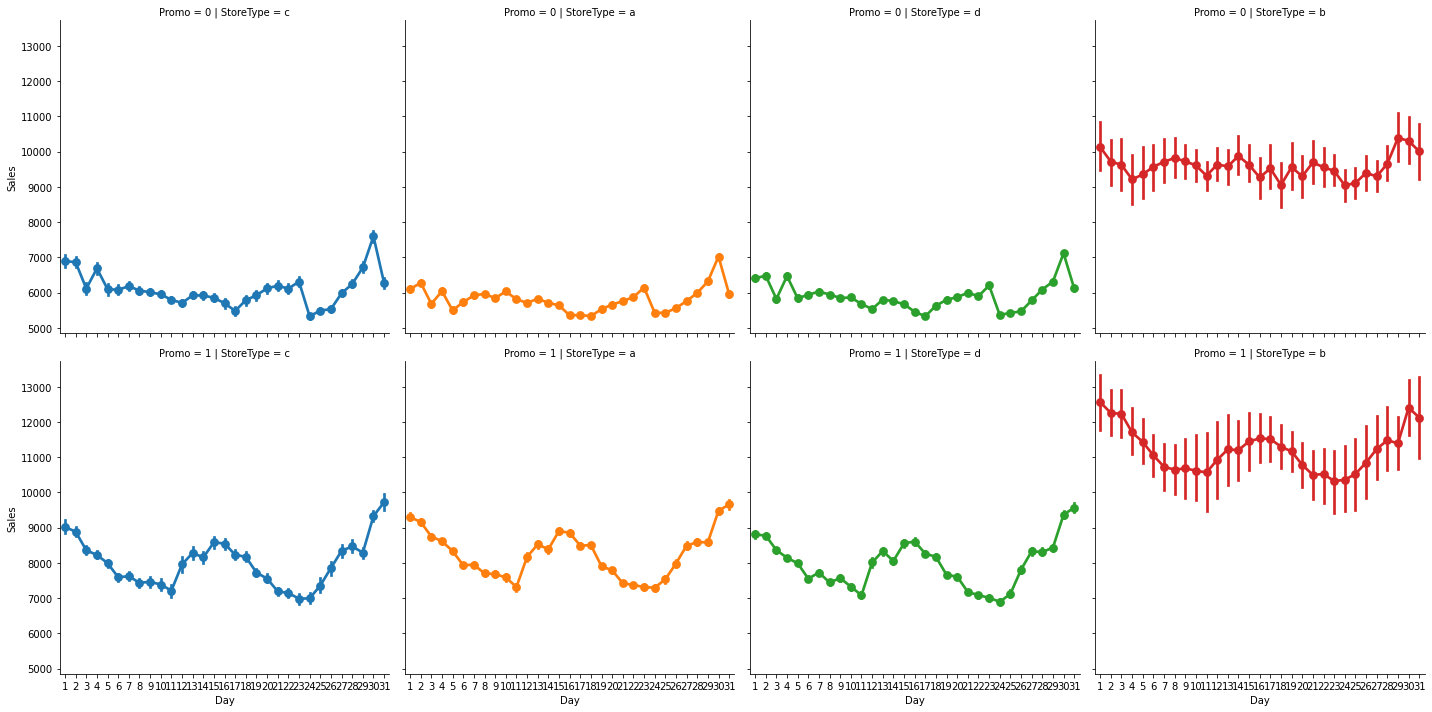

In [30]:
sns.factorplot(data = X_train, x = 'Day', y = "Sales", 
               col = 'StoreType', # per store type in cols
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               ) 

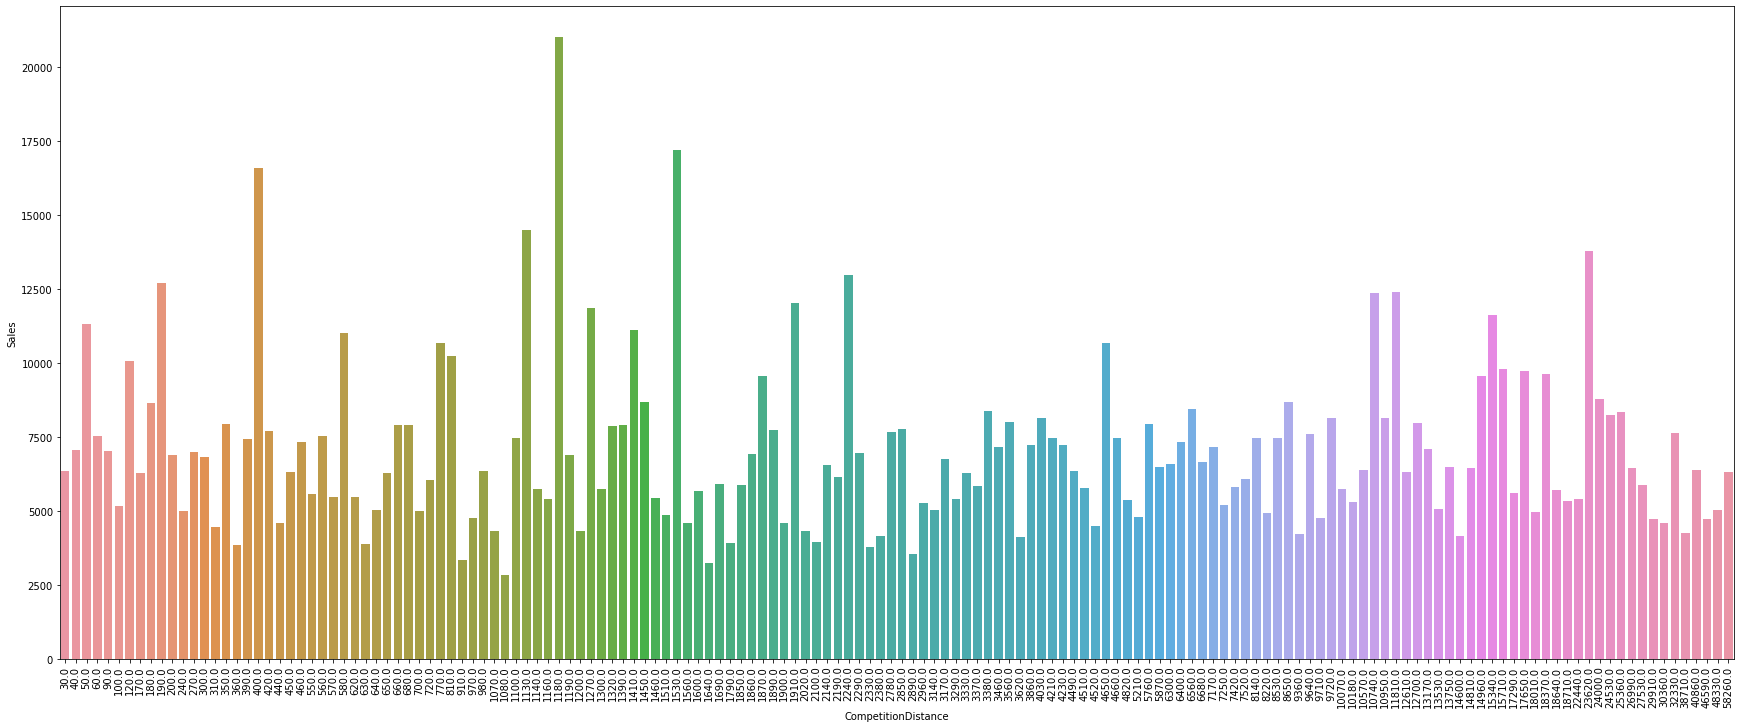

In [60]:
data_dis = X_train[X_train['CompetitionOpen']==True].groupby('CompetitionDistance')['Sales'].mean()
data_dis = data_dis.reset_index()
fig, ax = plt.subplots(figsize=(30, 12))
g = sns.barplot(data = data_dis, x = 'CompetitionDistance', y = "Sales", ax=ax)
_ = g.set_xticklabels(data_dis['CompetitionDistance'], rotation=90)  # 旋转 x 标签

In [0]:
def add_feature(df):
  avg_sale_per_store = X_train[["Store", "Sales", "Customers"]].groupby("Store").sum()
  avg_sale_per_store["AvgSalePerStore"] = avg_sale_per_store["Sales"] / avg_sale_per_store["Customers"]
  avg_sale_per_store.drop(['Sales', 'Customers'], axis=1, inplace=True)
  df = pd.merge(df, avg_sale_per_store, how="left", on="Store")

  groups = X_train[["Store", "Open"]].groupby("Store").mean()
  groups.rename(columns={"Open":"ShopAvgOpen"}, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")

  groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
  groups2 = X_train[X_train["StateHoliday"] != "0"][["Store", "Sales"]].groupby("Store").sum()
  groups = pd.merge(groups1, groups2, on="Store")
  groups["HolidayShopSales"] = groups["Sales_y"] / groups["Sales_x"]
  groups.drop(["Sales_x", "Sales_y"], axis=1, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")

  groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
  groups2 = X_train[X_train["IsPromoMonth"] == 1][["Store", "Sales"]].groupby("Store").sum()
  groups = pd.merge(groups1, groups2, on="Store")
  groups["PromoShopSales"] = groups["Sales_y"] / groups["Sales_x"]
  groups.drop(["Sales_x", "Sales_y"], axis=1, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")
  return df

In [0]:
X_train = add_feature(X_train)

In [65]:
avg_sale_per_store

,AvgSalePerStore
Store,
1,8.437366
2,8.482725
3,9.255808
4,7.292138
5,8.702634
...,...
1111,11.626239
1112,12.206623
1113,9.243499


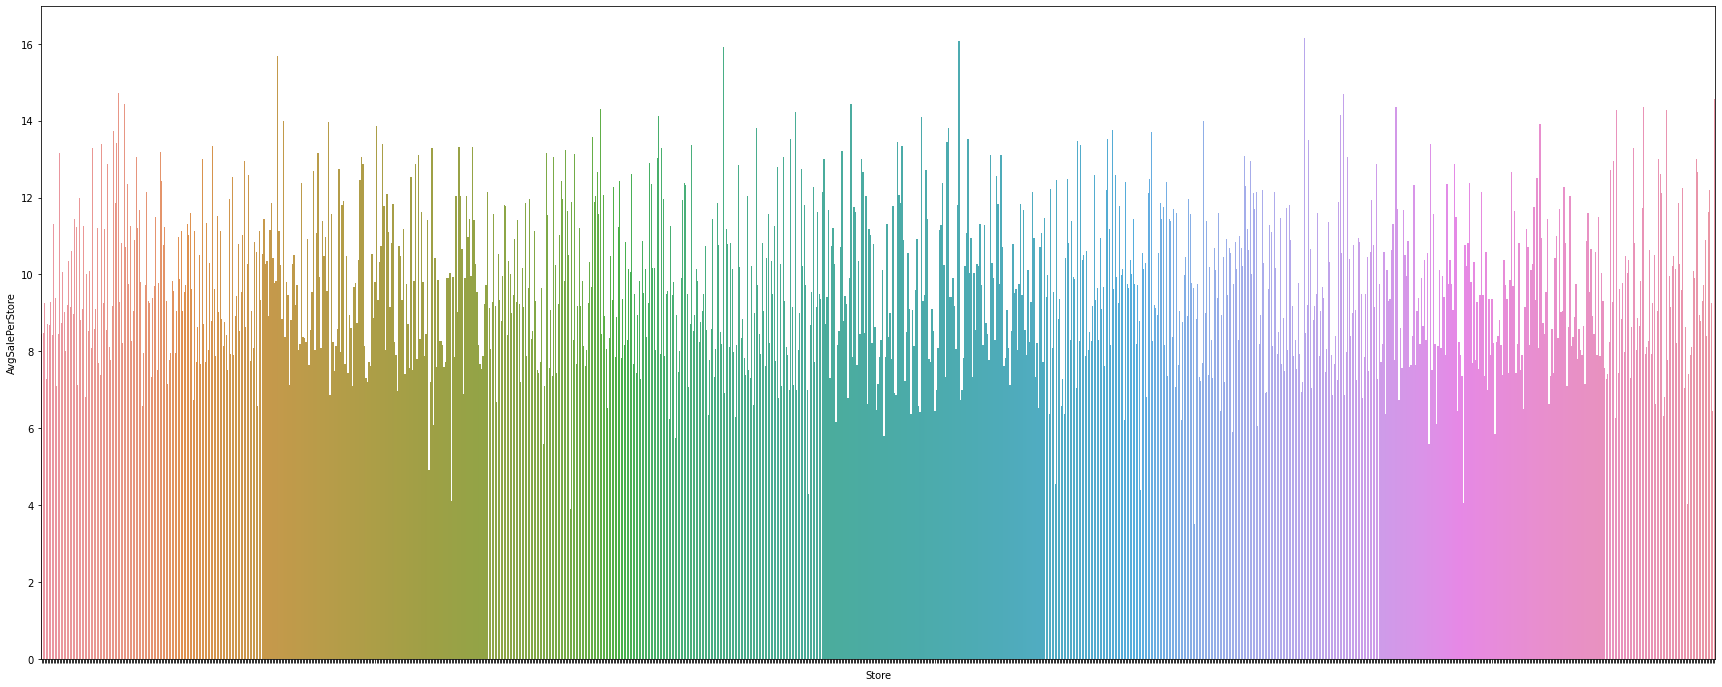

In [67]:
avg_sale_per_store = X_train[["Store", "Sales", "Customers"]].groupby("Store").sum()
avg_sale_per_store["AvgSalePerStore"] = avg_sale_per_store["Sales"] / avg_sale_per_store["Customers"]
avg_sale_per_store.drop(['Sales', 'Customers'], axis=1, inplace=True)
avg_sale_per_store = avg_sale_per_store.reset_index()
fig, ax = plt.subplots(figsize=(30, 12))
g = sns.barplot(x='Store',y='AvgSalePerStore', data=avg_sale_per_store, ax=ax)
_ = g.set(xticklabels=[])

In [0]:
X_train = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/train.csv', parse_dates=[2], low_memory=False)
X_test = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/test.csv', parse_dates=[3], low_memory=False)
store = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/store.csv')
map_dict = {
  'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  '0': 0,
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  'Jan,Apr,Jul,Oct': 1,
  'Feb,May,Aug,Nov': 2,
  'Mar,Jun,Sept,Dec': 3
}
X_train.sort_values(["Date"], inplace=True, kind="mergesort")
X_train.reset_index(drop=True, inplace=True)

X_test['Open'].unique()
X_test["Open"] = X_test['Open'].fillna(1) # 将缺失的值补充为 1

store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.fillna(0, inplace = True)

X_train = get_processed_data_with_store(X_train, store)
X_test = get_processed_data_with_store(X_test, store)
X_train = add_feature(X_train)
X_test = add_feature(X_test)

test_close_ind = np.where(X_test["Open"] == 0)[0]
X_train = X_train[X_train["Sales"] != 0]
X_train.drop(["Open"], axis=1, inplace=True)
X_test.drop(["Open"], axis=1, inplace=True)

for col in ['StateHoliday', 'Assortment', 'PromoInterval', 'StoreType']:
  X_train[col] = X_train[col].map(map_dict)
  X_test[col] = X_test[col].map(map_dict)

y_train = np.array(X_train["Sales"])
X_train.drop("Sales", axis=1, inplace=True)
X_train.drop("Customers", axis=1, inplace=True)
test_ID = X_test["Id"]
X_test.drop("Id", axis=1, inplace=True)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import xgboost as xgb

In [0]:
features = ['Store', 'PromoOpen', 'DayOfWeek', 'StateHoliday', 'StoreType', 'Month', 'Year', 'SchoolHoliday', 'Assortment', 'Promo', 'CompetitionDistance']
X_train = X_train[features]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [0]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

In [101]:
clf_a = LinearRegression()
clf_a.fit(X_train,y_train)
y_predict = clf_a.predict(X_valid)
print('LinearRegression',rmse(y_predict,y_valid))

LinearRegression 0.3856439594427774


In [104]:
clf_d = tree.DecisionTreeRegressor()
clf_d.fit(X_train,y_train)
print('DecisionTreeRegressor',rmse(clf_d.predict(X_valid),y_valid))

DecisionTreeRegressor 0.32263863259839887


In [106]:
clf_e = xgb.XGBRegressor()
clf_e.fit(X_train,y_train)
print('XGboost',rmse(clf_e.predict(X_valid),y_valid))

[19:56:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGboost 0.34551129089955


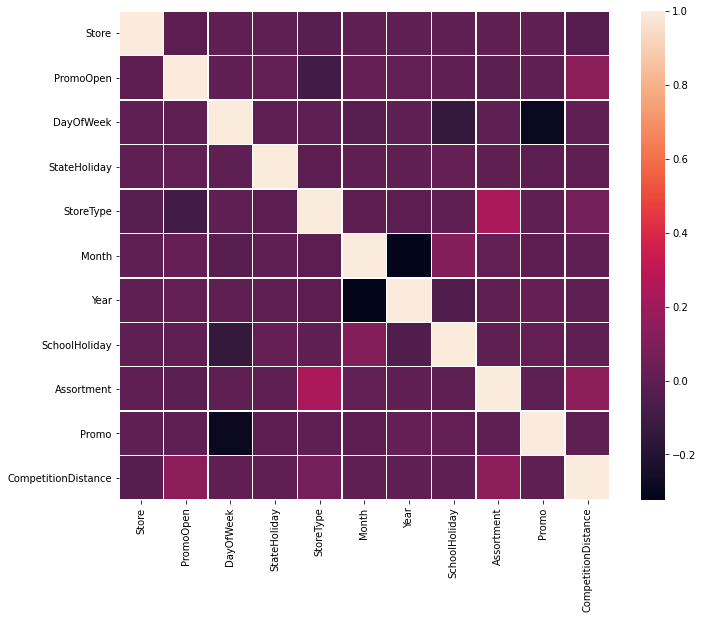

In [109]:
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(X_train.corr(), linewidths = .5, ax=ax)

In [111]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor()
clf_d.fit(X_train,y_train)
print('LGBMRegressor',rmse(clf_d.predict(X_valid),y_valid))


LGBMRegressor 0.31731794559368914
